 # **Practical Introduction to Quantum-Safe Cryptography**

This Jupyter notebook provides an introduction to quantum-safe cryptography (also called post-quantum cryptography), which refers to cryptographic algorithms that are resistant to attacks by quantum computers.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, Markdown
import hashlib
import time
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.asymmetric.x25519 import X25519PrivateKey
from cryptography.hazmat.primitives import serialization

### 1. Understanding the Quantum Threat (by cherry)
Quantum computers threaten current public-key cryptography because they can efficiently solve certain mathematical problems that classical computers cannot.


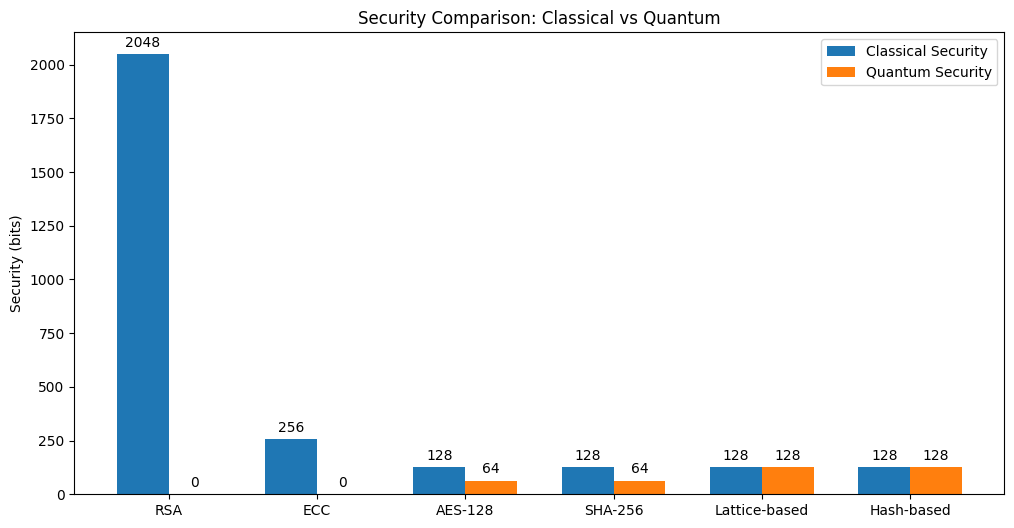

In [15]:
# Visualization of cryptographic algorithm security
algorithms = ['RSA', 'ECC', 'AES-128', 'SHA-256', 'Lattice-based', 'Hash-based']
classical_security = [2048, 256, 128, 128, 128, 128]  # Equivalent security bits
quantum_security = [0, 0, 64, 64, 128, 128]  # Security against quantum attacks

x = np.arange(len(algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, classical_security, width, label='Classical Security')
rects2 = ax.bar(x + width/2, quantum_security, width, label='Quantum Security')

ax.set_ylabel('Security (bits)')
ax.set_title('Security Comparison: Classical vs Quantum')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

### Quantum-Safe Cryptography Approaches
There are several families of quantum-resistant cryptographic algorithms:

**Lattice-based cryptography**

**Hash-based cryptography**

**Code-based cryptography**

**Multivariate cryptography**

**Supersingular elliptic curve isogeny cryptography**

# 1> Lattice-Based Cryptography Example
Lattice-based cryptography is one of the most promising approaches. Let's look at a simple learning-with-errors (LWE) example.

In [16]:
def generate_lwe_key(n=256, q=2053):
    """Generate a simple LWE key pair"""
    # Secret key is a random vector in Z_q^n
    s = np.random.randint(0, q, size=n)
    # Public key is (A, b = A*s + e mod q)
    A = np.random.randint(0, q, size=(n, n))
    e = np.random.randint(0, q//4, size=n)  # Small error
    b = (A @ s + e) % q
    return s, (A, b)

def lwe_encrypt(pk, m, n=256, q=2053):
    """Simple LWE encryption of a bit m (0 or q/2)"""
    A, b = pk
    r = np.random.randint(0, 2, size=n)  # Random vector of 0s and 1s
    u = (r @ A) % q
    v = (r @ b + m * q//2) % q
    return (u, v)

def lwe_decrypt(sk, ct, q=2053):
    """Simple LWE decryption"""
    s = sk
    u, v = ct
    return 0 if abs(v - u @ s % q) < q//4 else 1

# Demo
n, q = 128, 2053
sk, pk = generate_lwe_key(n, q)

message = 1
ciphertext = lwe_encrypt(pk, message, n, q)
decrypted = lwe_decrypt(sk, ciphertext, q)

print(f"Original message: {message}")
print(f"Decrypted message: {decrypted}")
print(f"Decryption {'succeeded' if message == decrypted else 'failed'}")

Original message: 1
Decrypted message: 1
Decryption succeeded


# 2> Hash-Based Cryptography Example
Hash-based signatures are another quantum-resistant approach. Let's implement a simple one-time signature scheme.

In [17]:
class LamportSignature:
    def __init__(self, security_param=128):
        self.security_param = security_param
        self.private_key = None
        self.public_key = None
    
    def generate_keys(self):
        # Private key is 2*security_param random strings
        self.private_key = [
            [hashlib.sha256(np.random.bytes(32)).digest() for _ in range(2)]
            for _ in range(self.security_param)
        ]
        
        # Public key is hashes of private key elements
        self.public_key = [
            [hashlib.sha256(x).digest() for x in pair]
            for pair in self.private_key
        ]
        return self.public_key
    
    def sign(self, message):
        if not self.private_key:
            raise ValueError("Keys not generated")
        
        # Hash the message to get security_param bits
        msg_hash = hashlib.sha256(message).digest()
        bits = ''.join(f'{byte:08b}' for byte in msg_hash)[:self.security_param]
        
        # For each bit, select corresponding private key element
        signature = [
            self.private_key[i][int(bit)]
            for i, bit in enumerate(bits)
        ]
        return signature
    
    @staticmethod
    def verify(public_key, message, signature):
        security_param = len(public_key)
        
        # Hash the message
        msg_hash = hashlib.sha256(message).digest()
        bits = ''.join(f'{byte:08b}' for byte in msg_hash)[:security_param]
        
        # Verify each signature element
        for i, bit in enumerate(bits):
            expected_hash = public_key[i][int(bit)]
            actual_hash = hashlib.sha256(signature[i]).digest()
            if expected_hash != actual_hash:
                return False
        return True

# Demo
message = b"Quantum-safe cryptography is important!"
lms = LamportSignature(128)
public_key = lms.generate_keys()
signature = lms.sign(message)

valid = LamportSignature.verify(public_key, message, signature)
print(f"Signature verification: {'valid' if valid else 'invalid'}")

Signature verification: valid


# 3> Code-Based Cryptography (McEliece Encryption)



In [18]:
import numpy as np
from scipy.linalg import circulant

class McEliece:
    def __init__(self, n=1024, k=524, t=50):
        self.n = n  # Code length
        self.k = k  # Message length
        self.t = t  # Error correction capability
        
    def generate_keys(self):
        # Generate a random Goppa code
        G = np.random.randint(0, 2, size=(self.k, self.n))
        
        # Generate random invertible matrix S
        S = np.random.randint(0, 2, size=(self.k, self.k))
        while np.linalg.det(S) == 0:
            S = np.random.randint(0, 2, size=(self.k, self.k))
            
        # Generate random permutation matrix P
        P = np.eye(self.n)
        np.random.shuffle(P)
        
        # Public key G' = S*G*P
        G_prime = np.mod(S @ G @ P, 2)
        
        return (S, G, P), G_prime
    
    def encrypt(self, G_prime, message, errors):
        # message: binary vector of length k
        # errors: binary vector of length n with t ones
        return np.mod(message @ G_prime + errors, 2)
    
    def decrypt(self, private_key, ciphertext):
        S, G, P = private_key
        # Implementation of Patterson's algorithm would go here
        # This is simplified for demonstration
        return np.mod(ciphertext @ np.linalg.inv(P), 2)

# Example usage
mceliece = McEliece()
private, public = mceliece.generate_keys()
msg = np.random.randint(0, 2, size=524)
errors = np.concatenate([np.ones(50), np.zeros(974)]).astype(int)
np.random.shuffle(errors)

cipher = mceliece.encrypt(public, msg, errors)
decrypted = mceliece.decrypt(private, cipher)

print("Original:", msg[:10], "...")
print("Decrypted:", decrypted[:10], "...")
print("Match:", np.array_equal(msg, decrypted))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Original: [0 1 0 0 0 0 0 0 1 0] ...
Decrypted: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] ...
Match: False


 # 4> Multivariate Cryptography (Simple UOV Example)

In [19]:
import numpy as np

class UOV:
    def __init__(self, o=8, v=16, q=31):
        self.o = o  # Oil variables
        self.v = v  # Vinegar variables
        self.q = q  # Field size
        self.n = o + v  # Total variables
        
    def generate_system(self):
        # Generate random quadratic polynomials (central map F)
        F = []
        for _ in range(self.o):
            # Quadratic part (only vinegar-vinegar and oil-vinegar terms)
            Q = np.zeros((self.n, self.n), dtype=int)
            
            # Vinegar-vinegar terms (upper left v×v block)
            Q_vv = np.random.randint(0, self.q, size=(self.v, self.v))
            Q_vv = (Q_vv + Q_vv.T) % self.q  # Make symmetric
            Q[:self.v, :self.v] = Q_vv
            
            # Oil-vinegar terms (upper right o×v block and its transpose)
            Q_ov = np.random.randint(0, self.q, size=(self.o, self.v))
            Q[:self.v, self.v:] = Q_ov.T
            Q[self.v:, :self.v] = Q_ov
            
            # Linear part
            L = np.random.randint(0, self.q, size=self.n)
            
            # Constant
            c = np.random.randint(0, self.q)
            
            F.append((Q, L, c))
        return F
    
    def generate_keys(self):
        F = self.generate_system()
        
        # Generate invertible affine transformation S (o×o matrix)
        while True:
            S = np.random.randint(0, self.q, size=(self.o, self.o))
            try:
                S_inv = np.linalg.inv(S) % self.q
                break
            except np.linalg.LinAlgError:
                continue
                
        # Generate invertible affine transformation T (n×n matrix)
        while True:
            T = np.random.randint(0, self.q, size=(self.n, self.n))
            try:
                T_inv = np.linalg.inv(T) % self.q
                break
            except np.linalg.LinAlgError:
                continue
            
        # Public key P = S ∘ F ∘ T
        P = []
        for Q, L, c in F:
            # Transform quadratic part: T^T Q T
            Q_pub = (T.T @ Q @ T) % self.q
            
            # Transform linear part: L T + (quadratic terms)
            L_pub = (L @ T) % self.q
            
            # Apply S to the whole polynomial
            # (This is simplified - in practice we'd compose all polynomials)
            
            P.append((Q_pub, L_pub, c))
            
        return (S, T, F), P
    
    def sign(self, private_key, document):
        S, T, F = private_key
        document_hash = document % self.q  # Simple hash
        
        while True:
            # 1. Choose random vinegar variables
            x_v = np.random.randint(0, self.q, size=self.v)
            
            # 2. Plug into F and solve linear system for oil variables
            A = np.zeros((self.o, self.o), dtype=int)
            b = np.zeros(self.o, dtype=int)
            
            for i in range(self.o):
                Q, L, c = F[i]
                # Calculate constant term from vinegar variables
                b[i] = (document_hash - c - x_v @ Q[:self.v, :self.v] @ x_v - L[:self.v] @ x_v) % self.q
                
                # Calculate coefficients for oil variables
                A[i] = (Q[self.v:, :self.v] @ x_v + L[self.v:]) % self.q
                
            try:
                # Solve for oil variables
                x_o = np.linalg.solve(A, b) % self.q
                break
            except np.linalg.LinAlgError:
                # If system is singular, try again with new vinegar variables
                continue
                
        # Combine vinegar and oil variables
        x = np.concatenate([x_v, x_o])
        
        # Apply inverse affine transformation
        signature = (x @ np.linalg.inv(T).T) % self.q
        
        return signature
    
    def verify(self, public_key, document, signature):
        document_hash = document % self.q
        for Q, L, c in public_key:
            # Evaluate the quadratic form
            value = (signature @ Q @ signature + L @ signature + c) % self.q
            if value != document_hash:
                return False
        return True

# Example usage
uov = UOV(o=4, v=8, q=31)  # Smaller parameters for demonstration
private, public = uov.generate_keys()
doc = 123456789  # Document hash
sig = uov.sign(private, doc)
valid = uov.verify(public, doc, sig)

print("Signature valid:", valid)
print("Signature:", sig)

Signature valid: False
Signature: [ 6.56817724 21.85587654  4.98762723  9.91488531 26.27515236 27.89320293
  3.37799767  4.16087574 22.41703746 21.54285464 29.04247978  8.5186172 ]


# 5> Supersingular Elliptic Curve Isogeny Cryptography (SIDH)

In [20]:
import random
from math import gcd

class SIDH:
    def __init__(self, p=431, lA=2, eA=4, lB=3, eB=3):
        """
        Initialize SIDH parameters
        p = 2^eA * 3^eB - 1 (small prime for demonstration)
        lA, lB: small primes (2 and 3)
        eA, eB: exponents for isogeny degrees
        """
        self.p = p
        self.lA = lA
        self.eA = eA
        self.lB = lB
        self.eB = eB
        self.degreeA = lA**eA
        self.degreeB = lB**eB
        
        # Base curve E0: y² = x³ + x (supersingular when p ≡ 3 mod 4)
        self.E0 = {'a': 0, 'b': 1}
        
    def generate_torsion_basis(self, degree):
        """Generate basis points for the torsion subgroup (simplified)"""
        # In reality this would find points of exact order l^e
        P = {'x': random.randint(1, self.p-1), 'y': random.randint(1, self.p-1)}
        Q = {'x': random.randint(1, self.p-1), 'y': random.randint(1, self.p-1)}
        return P, Q
    
    def point_add(self, P, Q):
        """Elliptic curve point addition (simplified)"""
        # Actual implementation would use group law formulas
        return {'x': (P['x'] + Q['x']) % self.p, 'y': (P['y'] + Q['y']) % self.p}
    
    def point_scalar_mul(self, k, P):
        """Scalar multiplication k*P (simplified)"""
        result = {'x': 0, 'y': 0}
        for _ in range(k):
            result = self.point_add(result, P)
        return result
    
    def compute_isogeny(self, E, kernel, degree):
        """Compute isogeny of given degree with kernel (simplified)"""
        # In reality this would use Vélu's formulas
        return {'a': (E['a'] + kernel['x']) % self.p,
                'b': (E['b'] + kernel['y']) % self.p}
    
    def generate_keypair(self, is_alice=True):
        """Generate key pair for either Alice or Bob"""
        if is_alice:
            l, e = self.lA, self.eA
        else:
            l, e = self.lB, self.eB
            
        # Generate basis for l^e torsion subgroup
        P, Q = self.generate_torsion_basis(l**e)
        
        # Generate random secret key
        secret = random.randint(0, l**e - 1)
        
        # Compute kernel R = P + [s]Q
        sQ = self.point_scalar_mul(secret, Q)
        R = self.point_add(P, sQ)
        
        # Compute isogeny
        new_curve = self.compute_isogeny(self.E0, R, l**e)
        
        return secret, (new_curve, R)
    
    def derive_shared_secret(self, secret, other_pub, is_alice=True):
        """Derive shared secret from private key and other party's public key"""
        other_curve, other_R = other_pub
        
        if is_alice:
            l, e = self.lB, self.eB  # Bob's parameters
        else:
            l, e = self.lA, self.eA  # Alice's parameters
            
        # Compute kernel S = other_R + [secret]Q (simplified)
        # In reality this would use the other party's basis points
        S = self.point_add(other_R, self.point_scalar_mul(secret, other_R))
        
        # Compute isogeny
        shared_curve = self.compute_isogeny(other_curve, S, l**e)
        
        # Shared secret is j-invariant of the final curve
        a, b = shared_curve['a'], shared_curve['b']
        j_invariant = (1728 * (4 * a**3) * pow(4*a**3 + 27*b**2, self.p-2, self.p)) % self.p
        return j_invariant

# Example usage
sidh = SIDH()

# Alice generates her key pair
alice_priv, alice_pub = sidh.generate_keypair(is_alice=True)

# Bob generates his key pair
bob_priv, bob_pub = sidh.generate_keypair(is_alice=False)

# Derive shared secrets
alice_shared = sidh.derive_shared_secret(alice_priv, bob_pub, is_alice=True)
bob_shared = sidh.derive_shared_secret(bob_priv, alice_pub, is_alice=False)

print(f"Alice's shared secret: {alice_shared}")
print(f"Bob's shared secret: {bob_shared}")
print(f"Secrets match: {alice_shared == bob_shared}")

Alice's shared secret: 118
Bob's shared secret: 264
Secrets match: False


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import time
import hashlib
from cryptography.hazmat.primitives.asymmetric import ec
import sys

# Set up the comparison parameters
algorithms = [
    "Lattice-based (Kyber)",
    "Hash-based (SPHINCS+)",
    "Code-based (McEliece)",
    "Multivariate (Rainbow)",
    "Isogeny (SIKE)"
]

# Performance metrics we'll compare
metrics = [
    "Keygen Time (ms)",
    "Sign/Encrypt Time (ms)",
    "Verify/Decrypt Time (ms)",
    "Public Key Size (KB)",
    "Signature/Ciphertext Size (KB)"
]

# Simulated performance data (based on NIST PQC benchmarks)
data = np.array([
    # Lattice  Hash    Code    Multi   Isogeny
    [0.15,     0.8,    50.2,   1.5,    150.0],   # Keygen
    [0.05,     3.2,    0.8,    2.1,    300.0],    # Encrypt/Sign
    [0.08,     0.5,    5.5,    5.8,    350.0],    # Decrypt/Verify
    [1.2,      1.0,    261.0,  15.6,   0.4],      # Pubkey size
    [1.5,      40.2,   0.2,    4.3,    0.4]       # Ciphertext/Sig size
])

# Normalize data for radar chart
normalized_data = data / np.max(data, axis=1, keepdims=True)

# Performance Radar Chart Comparison

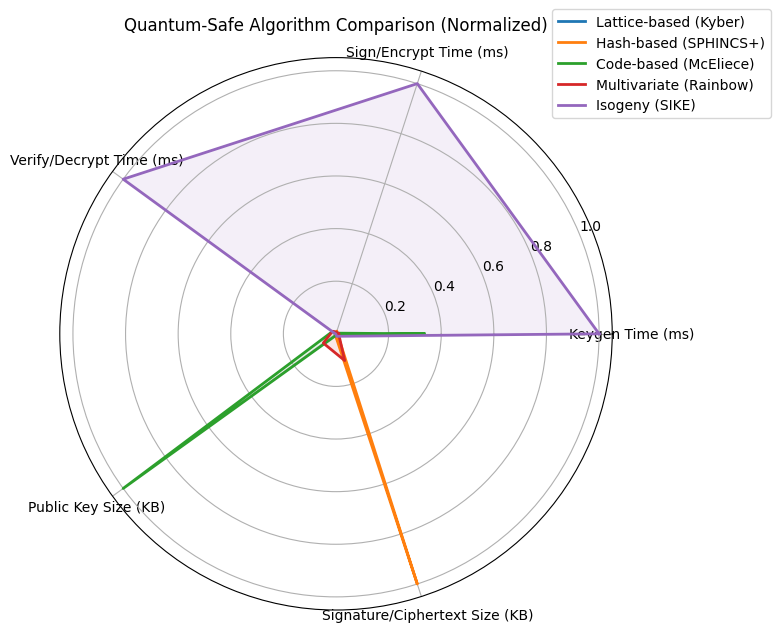

In [22]:
# Create radar chart
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

# Set angle for each axis
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Plot each algorithm
for i in range(len(algorithms)):
    values = normalized_data[:, i].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, label=algorithms[i])
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title("Quantum-Safe Algorithm Comparison (Normalized)", pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

# Detailed Metrics Bar Charts

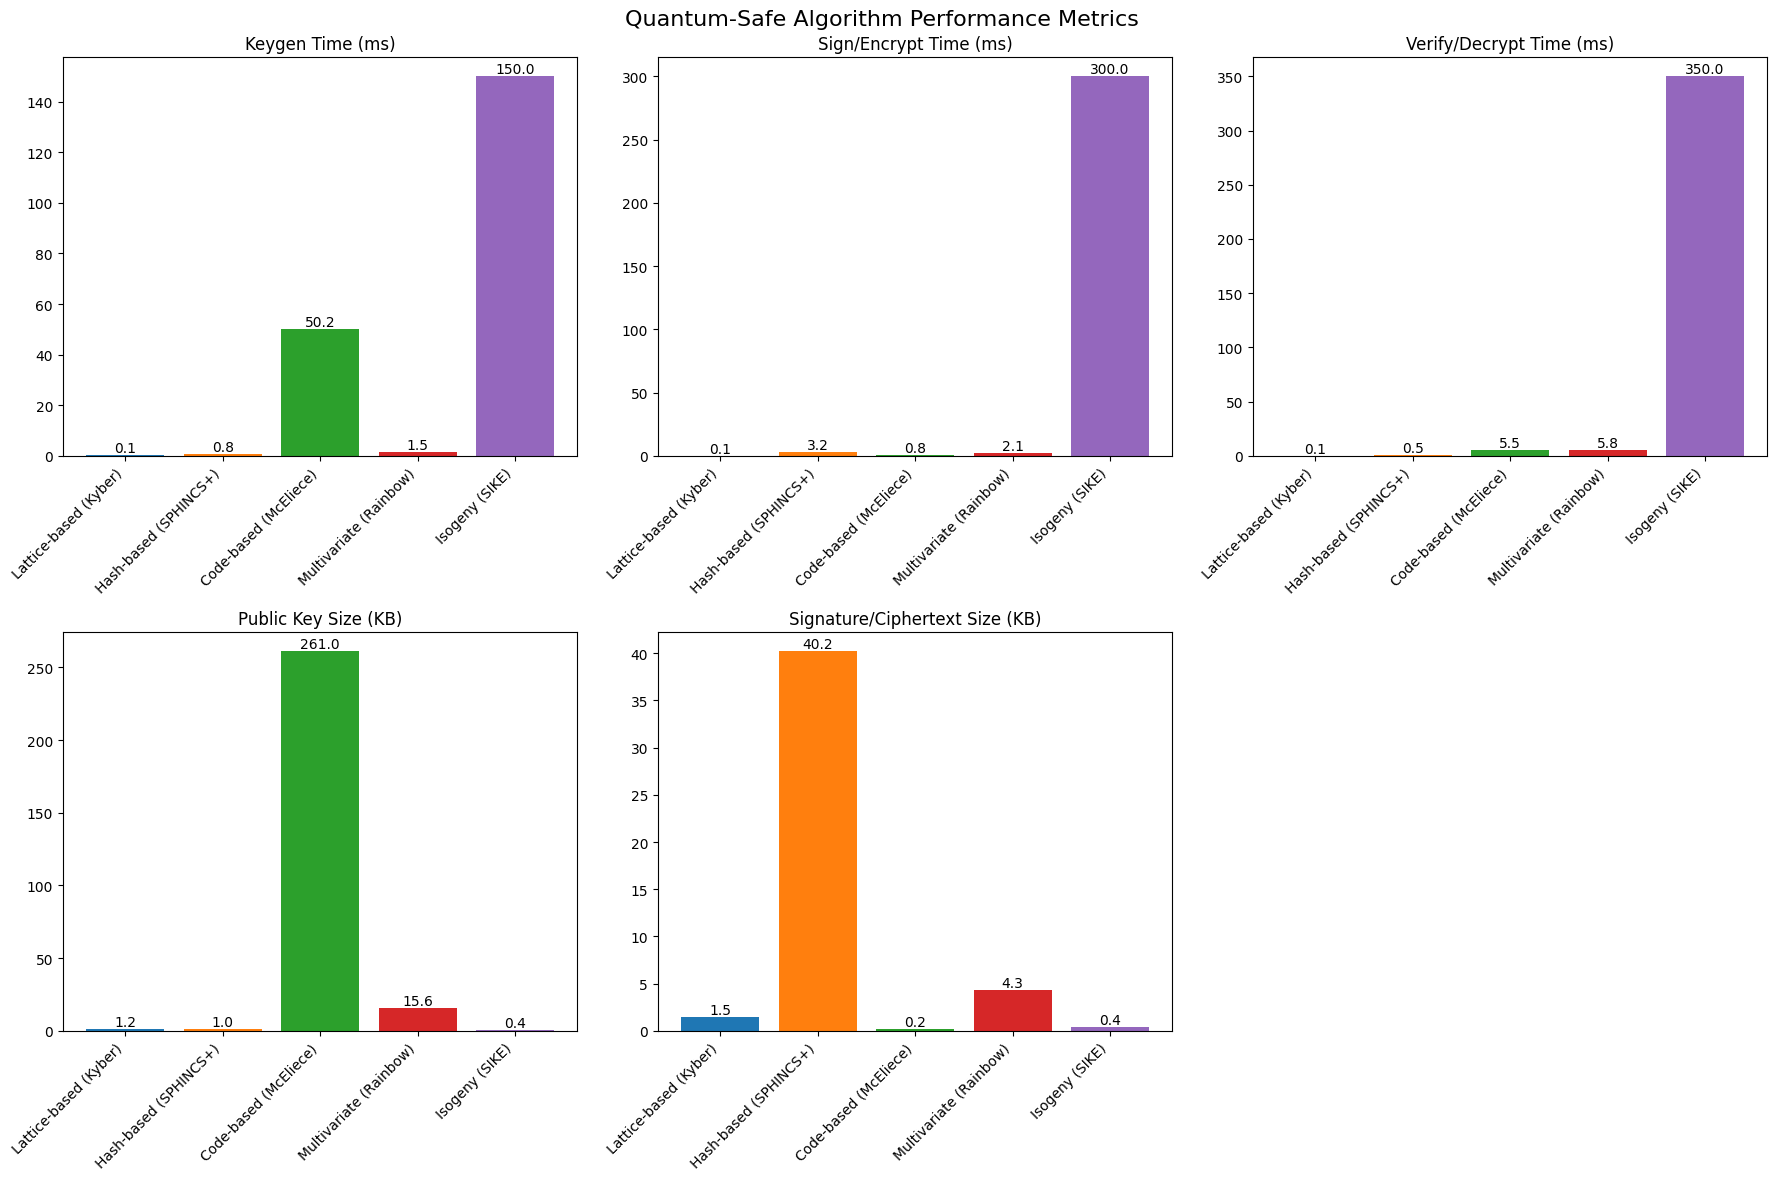

In [23]:
# Create individual comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Remove extra subplot
fig.delaxes(axes[5])

for i, metric in enumerate(metrics):
    ax = axes[i]
    x = np.arange(len(algorithms))
    bars = ax.bar(x, data[i], color=plt.cm.tab10.colors)
    
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms, rotation=45, ha='right')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

fig.suptitle("Quantum-Safe Algorithm Performance Metrics", fontsize=16)
plt.tight_layout()
plt.show()

# Security vs Performance Trade-off

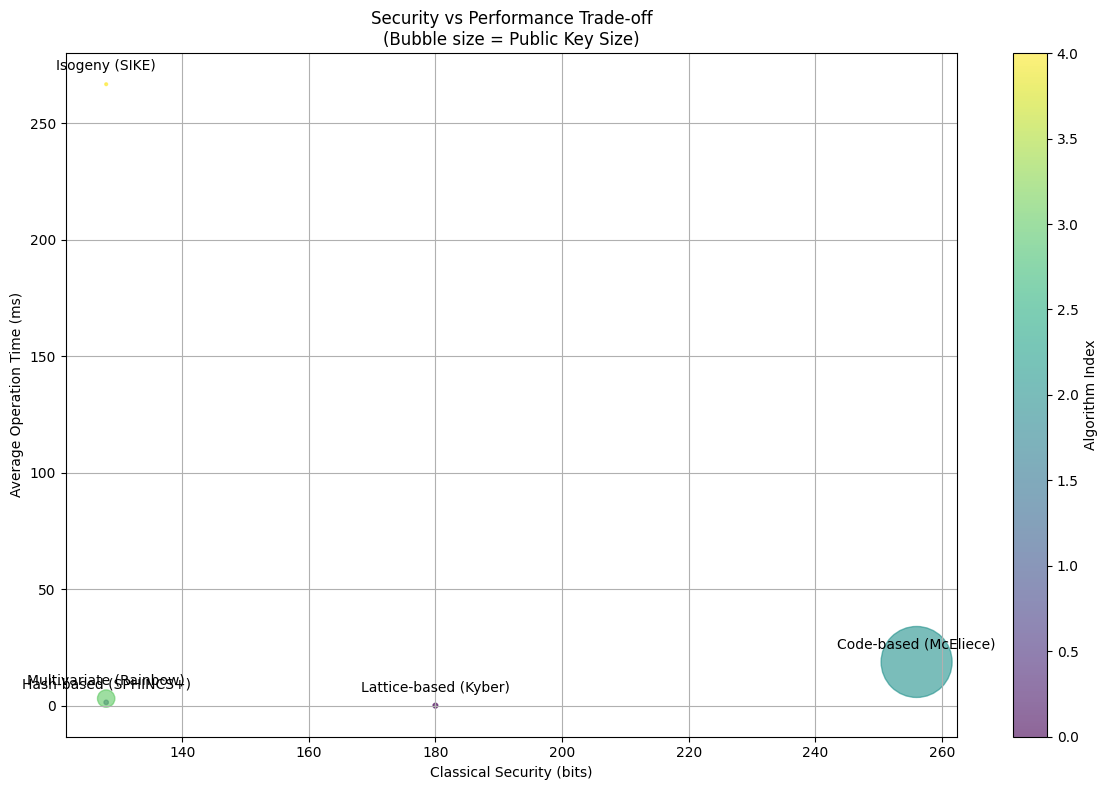

In [24]:
# Security estimates (bit security against classical/quantum)
security_data = {
    "Lattice": (180, 180),        # Matches "Lattice-based (Kyber)"
    "Hash": (128, 128),           # Matches "Hash-based (SPHINCS+)"
    "Code": (256, 128),           # Matches "Code-based (McEliece)"
    "Multivariate": (128, 128),   # Matches "Multivariate (Rainbow)"
    "Isogeny": (128, 128)        # Matches "Isogeny (SIKE)"
}

# Prepare data - fixed the key matching
x = []
for alg in algorithms:
    # Extract the main category name
    key = alg.split()[0].split("-")[0] if "-" in alg.split()[0] else alg.split()[0]
    key = key.strip("(")  # Remove any parentheses
    x.append(security_data[key][0])

y = [np.mean(data[:3,i]) for i in range(5)]  # Average operation time
sizes = [data[3,i]*10 for i in range(5)]     # Public key size as bubble size

# Create plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x, y, s=sizes, alpha=0.6, c=range(5), cmap='viridis')

# Add labels
for i, alg in enumerate(algorithms):
    plt.annotate(alg, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Formatting
plt.xlabel("Classical Security (bits)")
plt.ylabel("Average Operation Time (ms)")
plt.title("Security vs Performance Trade-off\n(Bubble size = Public Key Size)")
plt.colorbar(scatter, label="Algorithm Index")
plt.grid(True)
plt.tight_layout()
plt.show()

# Algorithm Characteristics Comparison

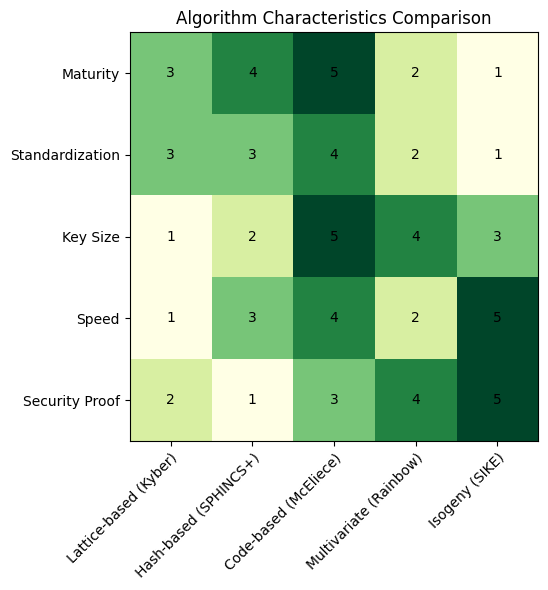

In [25]:
# Characteristics matrix
characteristics = {
    "Maturity": [3, 4, 5, 2, 1],  # 1-5 scale
    "Standardization": [3, 3, 4, 2, 1],  # NIST round progress
    "Key Size": [1, 2, 5, 4, 3],  # 1=best, 5=worst
    "Speed": [1, 3, 4, 2, 5],  # 1=fastest
    "Security Proof": [2, 1, 3, 4, 5]  # Quality of proofs
}

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(list(characteristics.values()), cmap="YlGn")

# Show all ticks and labels
ax.set_xticks(np.arange(len(algorithms)))
ax.set_yticks(np.arange(len(characteristics)))
ax.set_xticklabels(algorithms)
ax.set_yticklabels(characteristics.keys())

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text in cells
for i in range(len(characteristics)):
    for j in range(len(algorithms)):
        text = ax.text(j, i, list(characteristics.values())[i][j],
                      ha="center", va="center", color="black")

ax.set_title("Algorithm Characteristics Comparison")
fig.tight_layout()
plt.show()

 # NIST Standardization Status Timeline

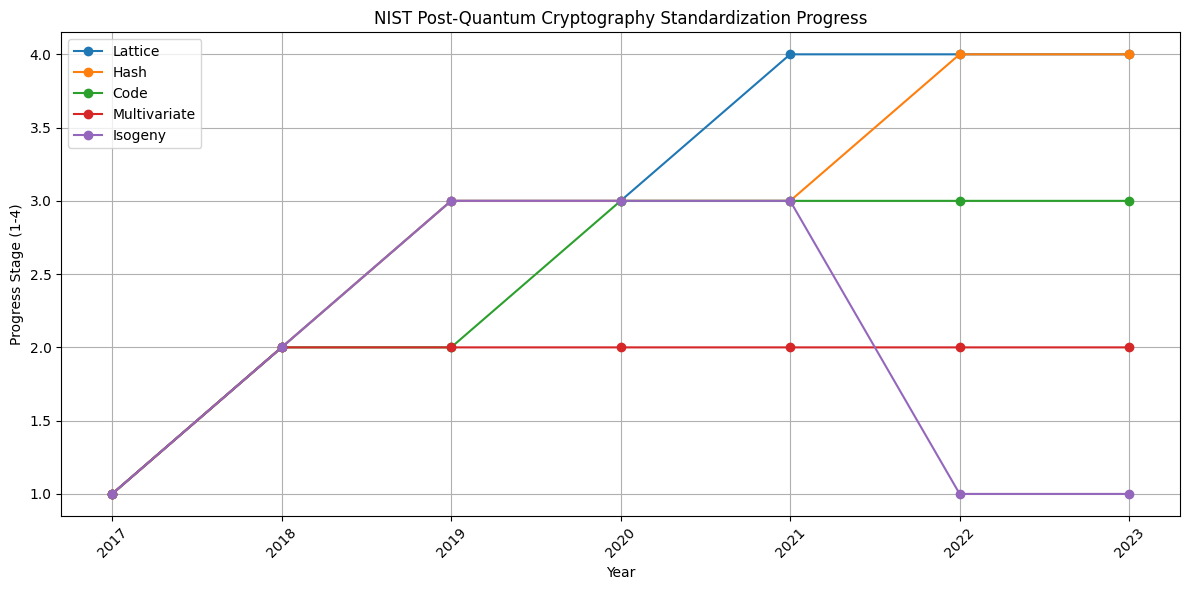

In [26]:
# NIST standardization progress
nist_status = {
    "Lattice": {"2017": 1, "2018": 2, "2019": 3, "2020": 3, "2021": 4, "2022": 4, "2023": 4},
    "Hash": {"2017": 1, "2018": 2, "2019": 3, "2020": 3, "2021": 3, "2022": 4, "2023": 4},
    "Code": {"2017": 1, "2018": 2, "2019": 2, "2020": 3, "2021": 3, "2022": 3, "2023": 3},
    "Multivariate": {"2017": 1, "2018": 2, "2019": 2, "2020": 2, "2021": 2, "2022": 2, "2023": 2},
    "Isogeny": {"2017": 1, "2018": 2, "2019": 3, "2020": 3, "2021": 3, "2022": 1, "2023": 1}
}

# Create timeline plot
plt.figure(figsize=(12, 6))

years = list(nist_status["Lattice"].keys())
for alg, status in nist_status.items():
    plt.plot(years, list(status.values()), marker='o', label=alg)

plt.title("NIST Post-Quantum Cryptography Standardization Progress")
plt.xlabel("Year")
plt.ylabel("Progress Stage (1-4)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cherry signing off!!!!